In [10]:
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt

In [11]:
# read file
expenses = pd.read_csv('Kosten_Silvester23_24.csv', sep=';', decimal=",") 
expenses['Price'] = expenses['Price'].astype(float)
drinks = pd.read_csv('trinkt_alk.csv', sep=';')
display(expenses)
display(drinks)


,Item,Price,Category,Name,Note
0,Bier,10.49,Alcohol,Adrian,NaN
1,Cola,1.19,Drink,Adrian,NaN
2,Wasser,0.54,Drink,Adrian,2 Flaschen angebrochen
3,Tee,1.29,Alcohol,Adrian,NaN
4,Limette,0.99,Alcohol,Adrian,NaN
5,Rum,5.99,Alcohol,Adrian,NaN
6,Zwiebeln,1.99,Food,Adrian,NaN
7,Ingwer,0.88,Food,Adrian,NaN
8,Linsen,3.98,Food,Adrian,NaN
9,Currypaste,2.99,Food,Adrian,NaN


,Name,Alcohol
0,Natascha,0
1,Adrian,0
2,Lukas,1
3,Moritz,1
4,Klara,1
5,Jannis,1
6,Philip,0
7,Pascal,1
8,Tom,0


In [12]:
sum_expenses = np.sum(expenses['Price'])
print('Total expenses: ', sum_expenses)

# food & non-alcoholic expenses
sum_non_alcoholic = np.sum(expenses[expenses['Category'] != 'Alcohol']['Price'])
print('Non-alcoholic expenses: ', sum_non_alcoholic)

# alcohol expenses
sum_alcohol = np.sum(expenses[expenses['Category'] == 'Alcohol']['Price'])
print('Alcohol expenses: ', sum_alcohol)

Total expenses:  60.269999999999996
Non-alcoholic expenses:  41.51
Alcohol expenses:  18.76


In [13]:
# drinks alcohol
alkis = drinks[drinks['Alcohol'] == 1]
print('drinks alc:\n', alkis)
print('\ndrinks no alc:\n', drinks[drinks['Alcohol'] == 0])

drinks alc:
      Name  Alcohol
2   Lukas        1
3  Moritz        1
4   Klara        1
5  Jannis        1
7  Pascal        1

drinks no alc:
        Name  Alcohol
0  Natascha        0
1    Adrian        0
6    Philip        0
8       Tom        0


In [14]:
# price per person
# alcohol
price_per_person_alcohol = round(sum_alcohol / len(alkis), 2)
print('price per person alcohol: ', price_per_person_alcohol)

# non-alcohol
price_per_person_non_alcohol = round(sum_non_alcoholic / len(drinks), 2)
print('price per person non-alcohol: ', price_per_person_non_alcohol)

price per person alcohol:  3.75
price per person non-alcohol:  4.61


In [15]:
# paid
grouped_expenses = expenses.groupby('Name')['Price'].sum()
print('grouped expenses:\n', grouped_expenses)

grouped expenses:
 Name
Adrian    38.38
Jannis     5.00
Moritz     3.00
Tom       13.89
Name: Price, dtype: float64


In [16]:
# money due per person
# before subracting the amount already paid
money_due = {p : price_per_person_non_alcohol + price_per_person_alcohol if p in alkis['Name'].values else price_per_person_non_alcohol for p in drinks['Name']}

# subtract the amount already paid
for p in grouped_expenses.index:
    if p in money_due.keys():
        money_due[p] = round(money_due[p] - grouped_expenses[p], 2)
        
print('money due:\n', money_due)

money due:
 {'Natascha': 4.61, 'Adrian': -33.77, 'Lukas': 8.36, 'Moritz': 5.36, 'Klara': 8.36, 'Jannis': 3.36, 'Philip': 4.61, 'Pascal': 8.36, 'Tom': -9.28}


In [17]:
# cash flows
creditors = [p for p in money_due.keys() if money_due[p] < 0]
cash_flows = {}
#print('creditors:\n', creditors)
for c in creditors:
    while (money_due[c] < 0) and (len([p for p in money_due.keys() if money_due[p] > 0]) > 1):
        #print('money due:\n', money_due[c])
        debtors = [p for p in money_due.keys() if money_due[p] > 0]
        #print('debtors:\n', debtors)
        for d in debtors:
            if (money_due[d] > 0) and (money_due[c] < 0):   
                money_paid = round(min(abs(money_due[c]), money_due[d]), 2)        
                print(d, ' pays ', c, ' ', money_paid)
                cash_flows[(d, c)] = money_paid
                money_due[d] = round(money_due[d] - money_paid, 2)
                money_due[c] = round(money_paid + money_due[c], 2)

Natascha  pays  Adrian   4.61
Lukas  pays  Adrian   8.36
Moritz  pays  Adrian   5.36
Klara  pays  Adrian   8.36
Jannis  pays  Adrian   3.36
Philip  pays  Adrian   3.72
Philip  pays  Tom   0.89
Pascal  pays  Tom   8.36


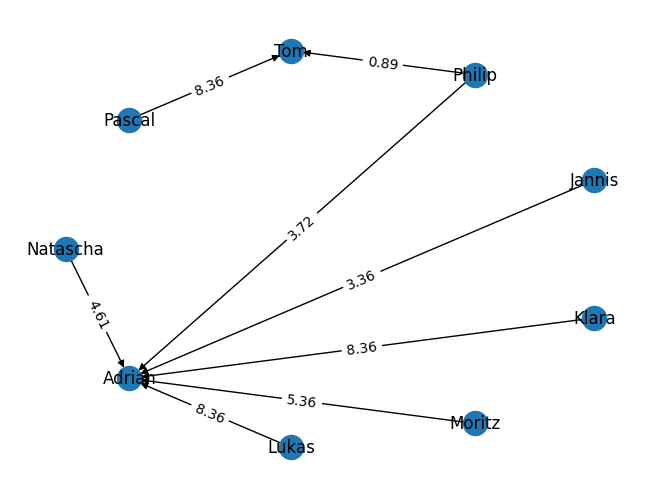

In [18]:
import networkx as nx
G = nx.DiGraph()
for f in cash_flows.keys():
    G.add_edge(f[0], f[1], weight=cash_flows[f])

pos=nx.shell_layout(G)
nx.draw(G,pos,with_labels=True)

# specifiy edge labels explicitly
edge_labels=dict([((u,v,),d['weight'])
for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

# show graphs
plt.savefig("plots/weighted_graph.png")
plt.show()
